In [1]:
from typing import Callable, Tuple

import numpy as np
import pandas as pd
from numba import prange, njit, typed, types
from tqdm.notebook import trange
from numpy.typing import NDArray
from numba import njit, prange
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing

In [2]:
def get_service_times() -> NDArray['float']:
    df = pd.read_csv('../data/service_times.csv')
    df.rename(columns={'TTI 0.95': 'service_time' }, inplace=True)
    df['service_time'] = df['service_time'].map(lambda time: float(time.replace('ms', '')))

    return np.array(df['service_time'])

In [3]:
service_times = get_service_times()

In [4]:
@njit
def arrive_cdf(n: int) -> float:
    return np.random.gamma(n, 0.299)
    
@njit
def leave_cdf() -> float:
    return np.random.exponential(510)

@njit
def departure_cdf() -> float:
    return np.random.choice(service_times) * 0.95 / 4

In [5]:
@njit
def get_next_event(
    arrival_time: float,
    request_times_queue: list,
    departure_time: float,
) -> (float, str, int):
    event_type = 'ARRIVAL'
    min_index = -1
    min_time = arrival_time

    if departure_time != -1 and departure_time < min_time:
        event_type = 'DEPARTURE'
        min_time = departure_time

    min_leave_time_index = -1
    min_leave_time = np.inf
    if len(request_times_queue) != 0:
        min_leave_time_index = np.argmin(request_times_queue)
    if min_leave_time_index != -1:
        min_leave_time = request_times_queue[min_leave_time_index]
        
    if min_leave_time < min_time:
        min_index = min_leave_time_index
        min_time = min_leave_time
        event_type = 'LEAVE'

    return min_time, event_type, min_index

In [6]:
@njit
def arrival(
    time: float,
    num_in_system: int,
    num_total_requests: int,
    leave_indicator: int,
    request_times_queue: list,
    departure_time: float,
    n: int,
    N: int,
) -> (float, int, int, int, list, float):
    num_in_system += 1 # увеличиваем число запросов в системе
    num_total_requests += 1

    if departure_time == -1: # если сервер свободен
        mu = departure_cdf()
        departure_time = time
        departure_time = time + mu # планируем обработку запроса
    else:
        if len(request_times_queue) == N:
            num_in_system -= 1 # считаем, что заявка покинула систему
            leave_indicator += 1 # увеличиваем индикатор выхода из системы
        else:
            gamma = leave_cdf()
            request_times_queue = np.append(request_times_queue, time + gamma)
    
    alpha = arrive_cdf(n)
    time += alpha
    return time, num_in_system, num_total_requests, leave_indicator, request_times_queue, departure_time

@njit
def departure(
    time: float,
    num_in_system: int,
    request_times_queue: list,
    departure_time: float,
) -> (int, list, list):
    num_in_system -= 1 # запрос обработан - уменьшаем число запросов в системе
    
    if (len(request_times_queue) == 0): # если очередь пуста
        departure_time = -1
    else:        
        gamma = departure_cdf()
        departure_time = time + gamma # планируем обработку запроса
        request_times_queue = np.delete(request_times_queue, 0)
    return num_in_system, request_times_queue, departure_time

@njit
def on_leave(
    time_index: float,
    num_in_system: int,
    leave_indicator: int,
    request_times_queue: list
) -> (int, int, list):
    num_in_system -= 1 # запрос ушёл - уменьшаем число запросов в системе
    leave_indicator += 1 # увеличиваем индикатор выхода из системы
    
    request_times_queue = np.delete(request_times_queue, time_index)

    return num_in_system, leave_indicator, request_times_queue

In [7]:
@njit
def update_area_num_in_system_stat(
    time: float,
    past_event_time: float,
    num_in_system: int,
    area_num_in_system: float
) -> (float, float):
    time_since_past_event = time - past_event_time
    past_event_time = time

    area_num_in_system += (num_in_system * time_since_past_event)
    return past_event_time, area_num_in_system

In [8]:
@njit
def num_in_system_iteration(
    T: float,
    n: int,
    N: int,
    return_value: str = 'average_requests_in_system'
) -> float:
    time = 0.0
    past_event_time = 0.0

    num_in_system = 0
    area_num_in_system: float = 0.0

    num_total_requests = 0
    leave_indicator = 0
    
    arrival_time = arrive_cdf(n)
    leave = leave_cdf()

    departure_time = -1
    request_times_queue = np.empty(0, dtype=np.float64)
    
    while time < T:
        time, event_type, time_index = get_next_event(arrival_time, request_times_queue, departure_time)
        past_event_time, area_num_in_system = update_area_num_in_system_stat(
            time,
            past_event_time,
            num_in_system,
            area_num_in_system
        )
        
        if event_type == 'ARRIVAL':
            arrival_time, num_in_system, num_total_requests, leave_indicator, request_times_queue, departure_time = arrival(
                time,
                num_in_system,
                num_total_requests,
                leave_indicator,
                request_times_queue,
                departure_time,
                n,
                N
            )
        elif event_type == 'DEPARTURE':
            num_in_system, request_times_queue, departure_time = departure(
                time,
                num_in_system,
                request_times_queue,
                departure_time
            )
        else:
            num_in_system, leave_indicator, request_times_queue = on_leave(
                time_index,
                num_in_system,
                leave_indicator,
                request_times_queue
            )

    average_requests_in_system = area_num_in_system / time
    loss_probability = leave_indicator / num_total_requests

    if return_value == 'average_requests_in_system':
        return average_requests_in_system
    if return_value == 'loss_probability':
        return loss_probability

In [9]:
@njit(parallel=True)
def num_in_system_iteration_resolver(
    T: float,
    N: int,
    n: int,
    max_queue_size: int,
    x_betta: float,
    eps: float = 1e-3,
    return_value: str = 'average_requests_in_system'
) -> float:
    N_new = N
    N_old = 0

    sum_data = 0
    sum_data_sq = 0
    while True: 
        for i in prange(N - N_old):
            value = num_in_system_iteration(T, n, max_queue_size, return_value)
            sum_data += value
            sum_data_sq += value ** 2
        E = sum_data / N
        D = (sum_data_sq / N) - (E ** 2)
        N_new = int(((x_betta ** 2) * D) / (eps ** 2))

        if N_new <= N:
            return E
        N_old = N
        N = N_new
        
        print(f'New N: {N}, old N: {N_old}')

In [10]:
MAX_SERVERS = 200
MIN_SERVERS = 1

servers_num = np.arange(MIN_SERVERS, MAX_SERVERS + 1)
loss_probabilities = np.empty(0)

T = 10000
iterations = 1000
max_queue_size = 10_000
eps = 1e-3
betta = 0.95
x_betta = stats.norm.ppf(betta)

for i in trange(MIN_SERVERS, MAX_SERVERS + 1):    
    loss_probability = num_in_system_iteration_resolver(
        T,
        iterations,
        i,
        max_queue_size,
        x_betta=x_betta,
        eps=eps,
        return_value = 'loss_probability'
    )
    print(f'Probability of loss: {loss_probability} for servers number: {i}')
    loss_probabilities = np.append(loss_probabilities, loss_probability)

with open('./round-robin/loss_probabilities.npy', 'wb') as f:
    np.save(f, loss_probabilities)

  0%|          | 0/200 [00:00<?, ?it/s]

Probability of loss: 0.9410902717140626 for servers number: 1
Probability of loss: 0.9330967693682433 for servers number: 2
Probability of loss: 0.9252399545094272 for servers number: 3
Probability of loss: 0.917311165762125 for servers number: 4
Probability of loss: 0.9091987827707102 for servers number: 5
Probability of loss: 0.9013496583101889 for servers number: 6
Probability of loss: 0.8935044472313721 for servers number: 7
Probability of loss: 0.8854128692721835 for servers number: 8
Probability of loss: 0.8774361786103102 for servers number: 9
Probability of loss: 0.8695956411156022 for servers number: 10
Probability of loss: 0.8616758324301713 for servers number: 11
Probability of loss: 0.8536847787703914 for servers number: 12
Probability of loss: 0.8456986574490098 for servers number: 13
Probability of loss: 0.8378678875691997 for servers number: 14
Probability of loss: 0.8296688468537713 for servers number: 15
Probability of loss: 0.821970088286861 for servers number: 16
Pro

In [11]:
MAX_SERVERS = 200
MIN_SERVERS = 1

servers_num = np.arange(MIN_SERVERS, MAX_SERVERS + 1)
requests_in_system_list = np.empty(0)

T = 10000
iterations = 1000
max_queue_size = 10_000
eps = 1e-0
betta = 0.95
x_betta = stats.norm.ppf(betta)

for i in trange(MIN_SERVERS, MAX_SERVERS + 1):    
    avarege_requests_in_system = num_in_system_iteration_resolver(
        T,
        iterations,
        i,
        max_queue_size,
        x_betta=x_betta,
        eps=eps,
        return_value = 'average_requests_in_system'
    )
    print(f'Avarege requests in system: {avarege_requests_in_system} for servers number: {i}')
    requests_in_system_list = np.append(requests_in_system_list, avarege_requests_in_system)

with open('./round-robin/requests_in_system_list.npy', 'wb') as f:
    np.save(f, requests_in_system_list)

  0%|          | 0/200 [00:00<?, ?it/s]

Avarege requests in system: 1605.7425708293047 for servers number: 1
Avarege requests in system: 796.5221128650857 for servers number: 2
Avarege requests in system: 526.8864041059081 for servers number: 3
Avarege requests in system: 392.1374930313757 for servers number: 4
Avarege requests in system: 311.3252795249924 for servers number: 5
Avarege requests in system: 257.16262971859175 for servers number: 6
Avarege requests in system: 218.4852146028906 for servers number: 7
Avarege requests in system: 189.62280001515154 for servers number: 8
Avarege requests in system: 167.28180354568497 for servers number: 9
Avarege requests in system: 149.18574900095138 for servers number: 10
Avarege requests in system: 134.65963493719002 for servers number: 11
Avarege requests in system: 122.26182303733613 for servers number: 12
Avarege requests in system: 111.95156344016141 for servers number: 13
Avarege requests in system: 102.91848822378907 for servers number: 14
Avarege requests in system: 95.355

In [12]:
def little_law(lambda_val: float, requests_in_system, loss_probability: float):
    return requests_in_system / (lambda_val * (1 - loss_probability))

In [13]:
def normalize_values(data: NDArray[float]) -> NDArray[float]:
    min = np.min(data)
    max = np.max(data)

    return (data - min) / (max - min)

In [14]:
requests_in_system_list = np.load('./round-robin/requests_in_system_list.npy')
loss_probabilities = np.load('./round-robin/loss_probabilities.npy')

response_times = np.empty(len(requests_in_system_list))
for i in range(len(response_times)):
    lambda_val =  1 / 0.299
    response_times[i] = little_law(lambda_val, servers_num[i] * requests_in_system_list[i], loss_probabilities[i])

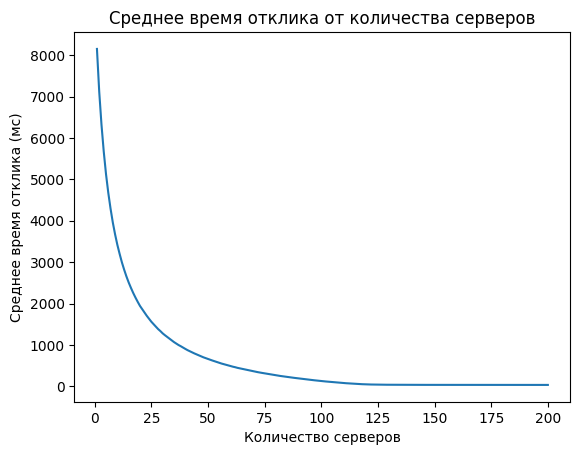

In [15]:
title = 'Среднее время отклика от количества серверов'
        
plt.ylabel('Среднее время отклика (мс)')
plt.xlabel('Количество серверов')
plt.title(title)

plt.plot(servers_num, response_times)

plt.show()

In [16]:
normalized_response_times = normalize_values(response_times)
normalized_servers_num = normalize_values(servers_num)

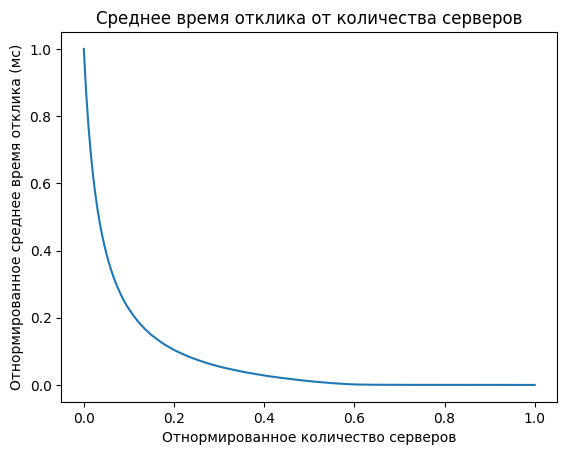

In [17]:
title = 'Среднее время отклика от количества серверов'
        
plt.ylabel('Отнормированное среднее время отклика (мс)')
plt.xlabel('Отнормированное количество серверов')
plt.title(title)

plt.plot(normalized_servers_num, normalized_response_times)

plt.show()

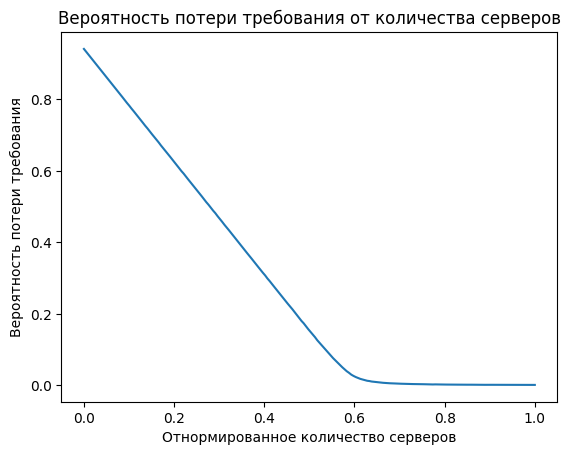

In [18]:
title = 'Вероятность потери требования от количества серверов'
        
plt.ylabel('Вероятность потери требования')
plt.xlabel('Отнормированное количество серверов')
plt.title(title)

plt.plot(normalized_servers_num, loss_probabilities)

plt.show()

In [19]:
def ideal_point_method(
    X: NDArray[float],
    Y: NDArray[float],
    Z: NDArray[float],
    ideal_point: (float, float, float)
) -> NDArray[float]:
    points_num = len(X)
    distances = np.empty(points_num, dtype=float)

    for i in range(points_num):
        distances[i] = np.sqrt((X[i] - ideal_point[0]) ** 2 + (Y[i] - ideal_point[1]) ** 2 + (Z[i] - ideal_point[2]) ** 2)

    return distances

def linear_convolution(
    X: NDArray[float],
    Y: NDArray[float],
    Z: NDArray[float],
    weights: (float, float, float)
) -> NDArray[float]:
    return weights[0] * X + weights[1] * Y + weights[2] * Z

In [20]:
ideal_point = (0, 0, 0)
ideal_point_method_result = ideal_point_method(normalized_servers_num, normalized_response_times, loss_probabilities, (0, 0, 0))

optimal_index = np.argmin(ideal_point_method_result)

optimal_number_of_servers = servers_num[optimal_index]
optimal_response_time = response_times[optimal_index]
optimal_loss_probability = loss_probabilities[optimal_index]

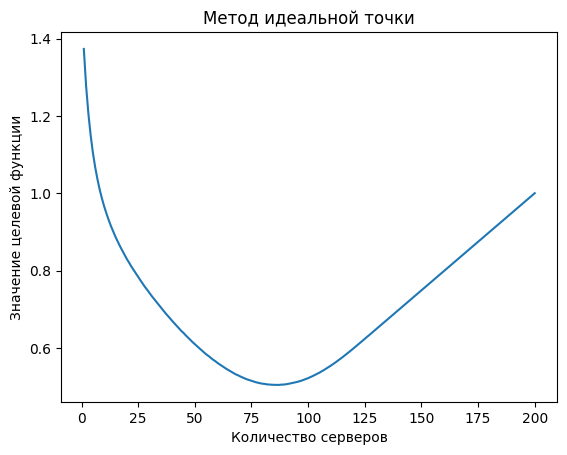

In [21]:
plt.title('Метод идеальной точки')

plt.ylabel('Значение целевой функции')
plt.xlabel('Количество серверов')

plt.plot(servers_num, ideal_point_method_result)

plt.show()

In [22]:
print(f'Оптимальное число серверов: {optimal_number_of_servers}')
print(f'Время отклика: {optimal_response_time}')
print(f'Вероятность потери заявки: {optimal_loss_probability}')

Оптимальное число серверов: 87
Время отклика: 213.1198499799279
Вероятность потери заявки: 0.25861580897847736


In [23]:
weights = (0.2, 0.5, 0.3)

linear_convolution_result = linear_convolution(normalized_servers_num, normalized_response_times, loss_probabilities, weights)

optimal_index = np.argmin(linear_convolution_result)
optimal_number_of_servers = servers_num[optimal_index]
optimal_loss_probability = loss_probabilities[optimal_index]

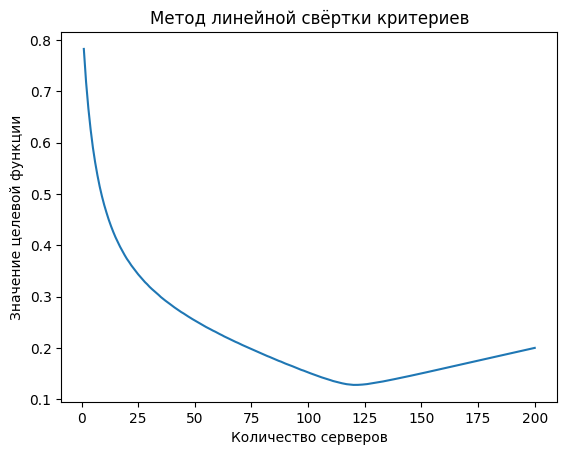

In [24]:
plt.title('Метод линейной свёртки критериев')

plt.ylabel('Значение целевой функции')
plt.xlabel('Количество серверов')

plt.plot(servers_num, linear_convolution_result)

plt.show()

In [25]:
print(f'Оптимальное число серверов: {optimal_number_of_servers}')
print(f'Среднее время отклика: {optimal_response_time}')
print(f'Вероятность потери заявки: {optimal_loss_probability}')

Оптимальное число серверов: 121
Среднее время отклика: 213.1198499799279
Вероятность потери заявки: 0.02244224464463308
